In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas import DataFrame, read_csv, set_option as pdopt, cut as pdcut
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from logging import getLogger, ERROR
from matplotlib import pyplot as plt
from warnings import filterwarnings
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from random import randint


# show real numbers instead of numbers in scientific notation, to the second decimal point
pdopt('display.float_format', '{:.2f}'.format)

# set max rows
pdopt('display.max_rows', 1000)

# set max cols
pdopt('display.max_columns', None)

# set logging level for mlflow and filter out autolog from warnings to keep notebook tidy
getLogger("mlflow").setLevel(ERROR)
getLogger("mlflow.utils.autologging_utils").setLevel(ERROR)
filterwarnings("ignore", message=".*autolog.*")

In [3]:
df = read_csv("./data/Bank-Telemarketing.csv")

In [4]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
df.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


In [6]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
df["education"].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [25]:
age_bins = [0, 17, 25, 60, 120]

In [27]:
labels = ["Youth", "Adult", "Older Adult", "Senior"]

In [30]:
df["age_group"] = pdcut(
    df["age"],
    bins=age_bins,
    labels=labels,
    right=True,
    include_lowest=True)

df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Adult
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Adult


<Axes: >

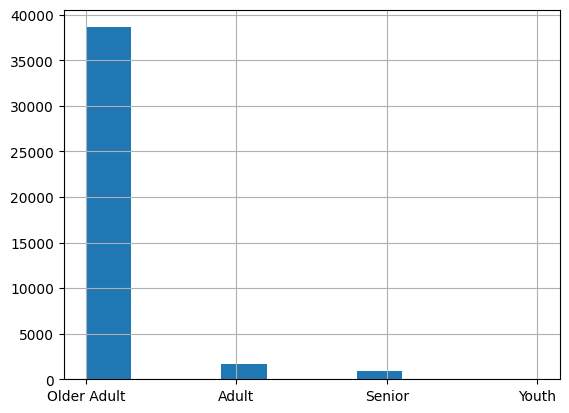

In [46]:
df["age_group"].hist()

In [8]:
# This class intakes a model and runs the prediction function upon itself. It is intended to run multiple times.
class MultiModelPredictor(BaseEstimator, ClassifierMixin):
    def __init__(self, model=None):
        # The candidate model is passed in.
        self.model = model

    def fit(self, X, y):
        # Clones the candidate model and fit it.
        self.model_ = clone(self.model)
        self.model_.fit(X, y)
        # Returns an instance of the updated object
        return self

    def predict(self, X):
        return self.model_.predict(X)

In [64]:
categorical_imputer = ("cat_imputer", SimpleImputer(strategy="most_frequent"))
one_hot_encoder = ("cat_encoder", OneHotEncoder(handle_unknown="ignore"))
numeric_imputer = ("num_imputer", SimpleImputer(strategy="median"))
ordinal_encoder = ("ord_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
scaler = ("scaler", StandardScaler())

features = {
    "target": "y",
    "categorical": ["job", "marital", "education", "contact", "month", "day_of_week", 
                    "campaign", "pdays", "previous", "poutcome", "previous"],
    "numerical": ["age", "duration", "euribor3m", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "pdays", "nr.employed"],
    "ordinal": ["default", "housing", "loan"]
}

In [65]:
numeric_imputer_scaler_pl = Pipeline(steps=[numeric_imputer, scaler])
categorical_imputer_pl = Pipeline(steps=[categorical_imputer, one_hot_encoder])
ordinal_encoder_pl = Pipeline(steps=[ordinal_encoder])

numeric_imputer_scaler = ("numeric_imputer_scaler", numeric_imputer_scaler_pl, features["numerical"])
categorical_imputer_encoder = ("categorical_imputer_encoder", categorical_imputer_pl, features["categorical"])
ordinal_encoder = ("ordinal_encoder", ordinal_encoder_pl, features["ordinal"])

In [66]:
# In this way, changing the target variable is as simple as updating the features dict
y = df[features["target"]].map({"no": 0, "yes": 1})
X = df.drop(features["target"], axis=1)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0,10000))

In [68]:
preprocessor = ("preprocessing", ColumnTransformer(transformers=[numeric_imputer_scaler, categorical_imputer_encoder, ordinal_encoder]))

cv_pipeline = Pipeline([preprocessor,
                        ("multi_models", MultiModelPredictor())
                       ])

In [69]:
param_grid = [
    {
        'multi_models__model': [RandomForestClassifier(n_jobs=-1, random_state=randint(0, 10000))],
        'multi_models__model__n_estimators': [50, 100],
        'multi_models__model__max_depth': [None, 10, 20]
    },
    {
        'multi_models__model': [SVC()],
        'multi_models__model__C': [0.1, 1, 10],
        'multi_models__model__kernel': ['linear', 'rbf']
    },
    {
        'multi_models__model': [LogisticRegression()],
        'multi_models__model__penalty': ['l2'],
        
    }
]

In [70]:
grid = GridSearchCV(cv_pipeline, param_grid, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)

In [71]:
grid.fit(X, y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV 2/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=5076), multi_models__model__max_depth=20, multi_models__model__n_estimators=50;, score=0.942 total time=   3.3s
[CV 3/3] END multi_models__model=SVC(), multi_models__model__C=0.1, multi_models__model__kernel=rbf;, score=0.759 total time=   7.2s
[CV 3/3] END multi_models__model=SVC(), multi_models__model__C=10, multi_models__model__kernel=rbf;, score=0.758 total time=   8.2s
[CV 1/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=5076), multi_models__model__max_depth=10, multi_models__model__n_estimators=100;, score=0.963 total time=   2.9s
[CV 2/3] END multi_models__model=SVC(), multi_models__model__C=0.1, multi_models__model__kernel=rbf;, score=0.942 total time=  18.3s
[CV 3/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=5076), multi_models__model__max_depth=None, multi_models__model__n_estimator

KeyboardInterrupt: 

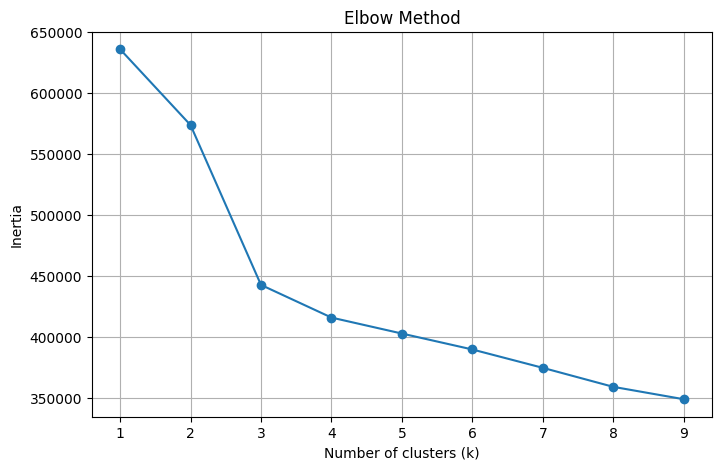

In [75]:
preprocessor = ColumnTransformer(transformers=[numeric_imputer_scaler, categorical_imputer_encoder, ordinal_encoder])

# 2) Build the KMeans pipeline using that ColumnTransformer instance:

kmeans_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("kmeans", KMeans(random_state=42))
])

# 3) Compute inertia over a range of k:

clusters = range(1, 10)
inertia_values = []

for k in clusters:
    kmeans_pipeline.set_params(kmeans__n_clusters=k)
    kmeans_pipeline.fit(X)                        # now X is transformed first, then KMeans.fit
    inertia_values.append(
        kmeans_pipeline.named_steps["kmeans"].inertia_
    )

# 4) Plot the elbow curve:

plt.figure(figsize=(8, 5))
plt.plot(clusters, inertia_values, "-o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.savefig("./paper/optimal_clusters.png")
plt.show()

Numeric features mean by cluster:
           age  duration  euribor3m  emp.var.rate  cons.price.idx  \
cluster                                                            
0       39.41    263.89       1.20         -2.02           92.99   
1       41.85    321.49       0.99         -2.10           93.34   
2       40.19    252.38       4.82          1.12           93.84   

         cons.conf.idx  pdays  nr.employed  
cluster                                     
0               -43.18 999.00      5077.78  
1               -38.34   6.01      5029.24  
2               -39.46 999.00      5213.42  


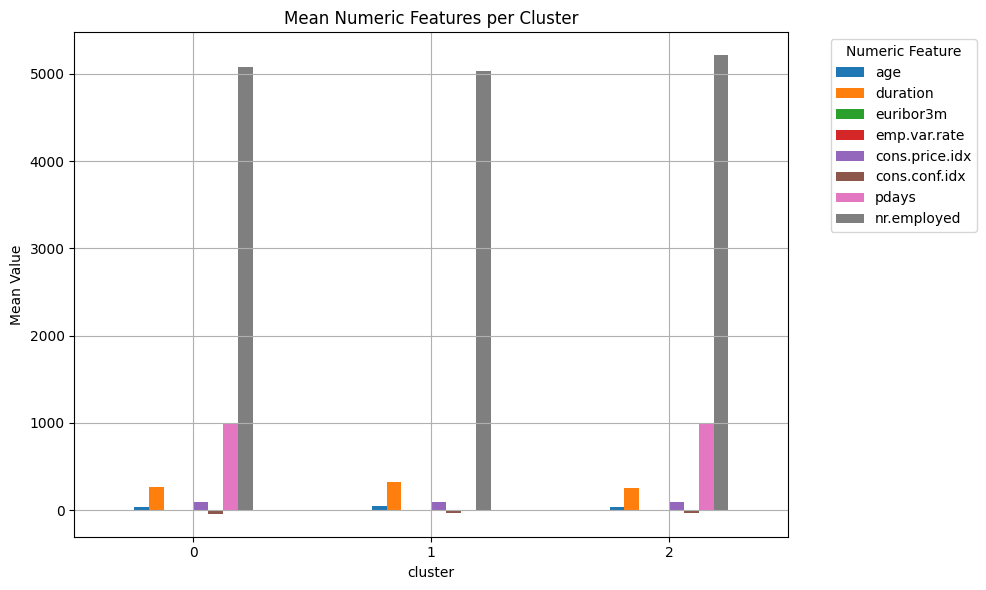

In [80]:
# Assume pipeline already fit with optimal_k=3
optimal_k = 3
kmeans_pipeline.set_params(kmeans__n_clusters=optimal_k)
kmeans_pipeline.fit(X)

# Assign cluster labels explicitly
cluster_labels = kmeans_pipeline.named_steps['kmeans'].labels_
df_with_clusters = X.copy()
df_with_clusters['cluster'] = cluster_labels

# Numeric feature means explicitly calculated per cluster
numeric_analysis = df_with_clusters.groupby('cluster')[features["numerical"]].mean()
print("Numeric features mean by cluster:\n", numeric_analysis)

categorical_analysis_specialty = (
    df_with_clusters.groupby('cluster')['education']
    .value_counts(normalize=True).unstack(fill_value=0)
)

# Clearly visualize numeric means per cluster
numeric_analysis.plot.bar(figsize=(10, 6))
plt.title("Mean Numeric Features per Cluster")
plt.ylabel("Mean Value")
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(title="Numeric Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [79]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00


In [81]:
import pandas as pd
import numpy as np

# 1a) Assume `df_with_clusters` already holds all original features + "cluster" + "y".
# For clarity, rebuild it from raw X, y, and cluster_labels:

X = df.drop("y", axis=1)                     # raw features
y = df["y"].map({"no": 0, "yes": 1})          # numeric target
labels = kmeans_pipeline.named_steps["kmeans"].labels_
df_with_clusters = X.copy()
df_with_clusters["cluster"] = labels
df_with_clusters["y"] = y.values

# 1b) Compute the proportion (or count) of y=1 inside each cluster:
cluster_counts = df_with_clusters.groupby("cluster")["y"].agg(
    total_count="count",
    positives="sum"
)
cluster_counts["pct_positive"] = (
    cluster_counts["positives"] / cluster_counts["total_count"]
)
print(cluster_counts)

         total_count  positives  pct_positive
cluster                                      
0              12027       2338          0.19
1               1515        967          0.64
2              27646       1335          0.05
